In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
mdata= pd.read_csv('train_imperson_without4n7_balanced_data.csv')
X, Y = mdata.loc[:, mdata.columns != '155'], mdata['155']

#eliminate features with 0 standard deviation
X1_sigma = X.loc[:, (X.std()>0)]

In [14]:
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV
initial_selection = {0, 32, 2, 34, 72, 11, 48, 49, 18, 20, 22, 57, 29, 31}


In [15]:
X_top_features = X1_sigma.iloc[:, list(initial_selection)]

In [16]:
# shuffle the rows
from numpy import random, arange
indexes =  arange(Y.shape[0])
random.shuffle(indexes)
X_cv = X_top_features.iloc[indexes,:]
Y_cv = Y.iloc[indexes]

In [17]:
%%time
cb = CatBoostClassifier(verbose=False, early_stopping_rounds=50)
rfecv = RFECV(cb, scoring="accuracy", n_jobs=-1, verbose=1)
rfecv.fit(X_cv, Y_cv)

/home/dave/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
CPU times: user 24min 31s, sys: 1min 19s, total: 25min 51s
Wall time: 23min 19s


RFECV(cv='warn',
      estimator=<catboost.core.CatBoostClassifier object at 0x7fa54ce8a3c8>,
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=1)

In [18]:
rfecv.n_features_

6

In [19]:
rfecv.ranking_

array([6, 4, 1, 2, 8, 1, 3, 9, 5, 7, 1, 1, 1, 1])

In [20]:
rfecv.grid_scores_

array([0.98148263, 0.99818639, 0.9991035 , 0.99990726, 0.99993817,
       0.99995878, 0.99995878, 0.99995878, 0.99995878, 0.99994848,
       0.99990726, 0.99989695, 0.99992787, 0.99990726])

In [21]:
rfecv.support_

array([False, False,  True, False, False,  True, False, False, False,
       False,  True,  True,  True,  True])

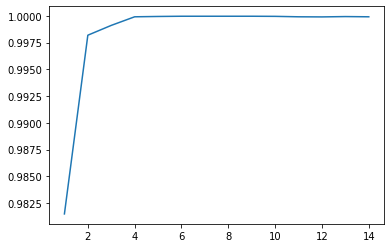

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

# Validating the 6 selected features using 5-fold CV

In [31]:
from sklearn.model_selection import cross_validate

X_top_6 = X_cv[X_cv.columns[rfecv.support_]]

cb = CatBoostClassifier(verbose=500, early_stopping_rounds=50)
%time cb_cv = cross_validate(cb, X_top_6, Y_cv, cv=5, scoring="accuracy")
cb_cv

Learning rate set to 0.057413
0:	learn: 0.4969230	total: 26.4ms	remaining: 26.4s
500:	learn: 0.0001222	total: 8.93s	remaining: 8.89s
999:	learn: 0.0001222	total: 16.4s	remaining: 0us
Learning rate set to 0.057413
0:	learn: 0.4939848	total: 29.7ms	remaining: 29.7s
500:	learn: 0.0001004	total: 9.07s	remaining: 9.04s
999:	learn: 0.0000942	total: 16.9s	remaining: 0us
Learning rate set to 0.057413
0:	learn: 0.4962508	total: 26.4ms	remaining: 26.3s
500:	learn: 0.0001067	total: 9.39s	remaining: 9.36s
999:	learn: 0.0001067	total: 16.9s	remaining: 0us
Learning rate set to 0.057413
0:	learn: 0.4947954	total: 27.1ms	remaining: 27.1s
500:	learn: 0.0001389	total: 9.15s	remaining: 9.12s
999:	learn: 0.0001389	total: 16.6s	remaining: 0us
Learning rate set to 0.057413
0:	learn: 0.4947399	total: 26.5ms	remaining: 26.5s
500:	learn: 0.0001834	total: 8.7s	remaining: 8.67s
999:	learn: 0.0001834	total: 16.1s	remaining: 0us
CPU times: user 10min 14s, sys: 30.9 s, total: 10min 45s
Wall time: 1min 28s


{'fit_time': array([17.38743424, 17.89787388, 18.17471766, 17.69102573, 17.14631081]),
 'score_time': array([0.01382089, 0.0118432 , 0.01252604, 0.01238298, 0.01172662]),
 'test_score': array([0.99994848, 0.99989696, 0.99994847, 0.99969085, 0.99984542])}

In [32]:
cb_cv['test_score'].mean()

0.9998660378103773

# Conclusion

Using RFECV we have reduced our 14 best features down to 6 features while still retaining an average accuracy rate of 99.987% on 5-fold cross validation.  However the run time for fitting the model has only been reduced by a small amount, going from an average of 19.19 seconds to 17.66 seconds.  Similarly the scoring time went down from 0.0136 seconds to 0.0125 seconds.

In [39]:
# get the top column names/numbers from the original dataframe: 
list(X_top_6.columns)

['8', '38', '67', '119', '76', '78']